In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# Load in dataset
df_housing = pd.read_csv('../Data/train.csv')

In [3]:
# Get predictors that you want
X = df_housing[['GrLivArea','GarageArea','FullBath','YearBuilt','GarageCars']]
X = add_constant(X)
y = 'SalePrice'

In [4]:
# Transform columns to make to them usable for linear regression
df_housing['LogSalePrice'] = np.log(df_housing['SalePrice'])
y = df_housing['LogSalePrice']

In [5]:
# Check for multicollinearity and adjust predictors accordingly
for index,col in enumerate(X.columns):
    if col == 'const': continue
    print(f'{col}: {variance_inflation_factor(X.values, index)}')

GrLivArea: 1.9795279454407528
GarageArea: 4.684423217353367
FullBath: 2.1172692446625874
YearBuilt: 1.6680132350708228
GarageCars: 5.080189099198332


In [6]:
# Drop Garage Cars, because VIF > 5
X = X.drop('GarageCars',axis =1)
X = add_constant(X)

In [7]:
# New VIFs
for index,col in enumerate(X.columns):
    if col == 'const': continue
    print(f'{col}: {variance_inflation_factor(X.values, index)}')
X = X.drop('const',axis =1)

GrLivArea: 1.9755437431250817
GarageArea: 1.603503478105227
FullBath: 2.0857130961157835
YearBuilt: 1.5919235384670054


In [8]:
X['AC'] = np.where(df_housing['CentralAir'] == 'Y',1,0) 

In [9]:
# Split into test and train data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [10]:
# Fit linear regression model
lin_reg = LinearRegression()
lin_reg.fit(X_train,y_train)
print(f'log(SalePrice) = {lin_reg.intercept_:.4f} ',end ='')
for B,x in zip(lin_reg.coef_,X.columns):
    print(f'+ {B:.4f}*({x})', end='')

log(SalePrice) = 2.8337 + 0.0004*(GrLivArea)+ 0.0004*(GarageArea)+ 0.0073*(FullBath)+ 0.0042*(YearBuilt)+ 0.2106*(AC)

In [11]:
# Make predictions on test data and calculate performace metrics
y_pred = lin_reg.predict(X_test)
print("MSE: %.2f" % mean_squared_error(y_test, y_pred))
print("R^2: %.2f" % r2_score(y_test, y_pred))

MSE: 0.04
R^2: 0.77


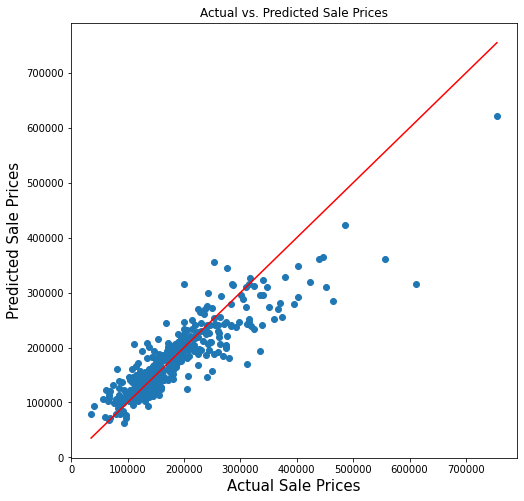

In [12]:
plt.figure(figsize=(8,8))
actual = np.exp(y_test)
predicted = np.exp(y_pred)
plt.scatter(actual,predicted)
p1 = max(max(predicted), max(actual))
p2 = min(min(predicted), min(actual))
plt.plot([p1, p2], [p1, p2], 'r-')
plt.xlabel('Actual Sale Prices',fontsize = 15)
plt.ylabel('Predicted Sale Prices',fontsize = 15)
plt.title('Actual vs. Predicted Sale Prices')
plt.show()

In [13]:
# Run model on test.csv
df_housing_test = pd.read_csv('../Data/test.csv')
df_housing_test['AC'] = np.where(df_housing_test['CentralAir'] == 'Y',1,0)
X_test = df_housing_test[X.columns]
y_pred = lin_reg.predict(X_test.fillna(0))
y_pred = np.exp(y_pred)
submission = pd.DataFrame({'Id': df_housing_test['Id'],'SalePrice': y_pred})
submission

,Id,SalePrice
0,1461,143115.699128
1,1462,138789.732193
2,1463,197792.252659
3,1464,195771.749709
4,1465,171903.002337
...,...,...
1454,2915,116881.897337
1455,2916,132123.489395
1456,2917,150717.886843
1457,2918,122426.922875


In [14]:
# Make submission.csv
submission.to_csv('submission.csv', index=False)